# 🎓 Real-Time Exam Proctoring System

## System Architecture (Real-Time Pipeline):
**Frame → Process → Display** (Repeat for each frame)

1. **Capture Frame** → From webcam/video stream
2. **YOLOv11s-Pose** → Detect students and keypoints
3. **DeepSORT** → Track with unique IDs
4. **Skeleton Generation** → Create skeleton ROI
5. **ResNet50V2** → Extract 512-d embeddings
6. **LSTM** → Classify behavior
7. **Display Result** → Show annotated frame immediately

**No upload/download delays - everything happens in real-time!**

---

## 📦 1. Installation and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install -U ultralytics
!pip install deep-sort-realtime
!pip install opencv-python-headless
!pip install tensorflow==2.13.0
!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn
!pip install pillow

print("✅ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 70.9 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0
✅ All packages installed successfully!


## 📚 2. Import Libraries

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import ultralytics
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, TimeDistributed
from tensorflow.keras.applications import ResNet50V2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import deque, defaultdict
import os
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image as IPImage
import time
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Ultralytics version: {ultralytics.__version__}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0
OpenCV version: 4.13.0
Ultralytics version: 8.4.13


## 🦴 3. Skeleton Generation Module

In [ ]:
class SkeletonGenerator:
    """Generate skeleton images from pose keypoints"""

    def __init__(self, img_size=(224, 224)):
        self.img_size = img_size

    def create_skeleton_image(self, keypoints, bbox):
        """
        Create skeleton image from keypoints
        Args:
            keypoints: Array of shape (13, 3) containing [x, y, confidence]
            bbox: Bounding box [x1, y1, x2, y2]
        Returns:
            skeleton_img: RGB skeleton image (224, 224, 3)
        """
        x1, y1, x2, y2 = map(int, bbox)
        width = x2 - x1
        height = y2 - y1

        # Create black canvas
        canvas = np.zeros((height, width, 3), dtype=np.uint8)

        # Adjust keypoints to ROI coordinates
        adjusted_kpts = keypoints.copy()
        adjusted_kpts[:, 0] -= x1  # Adjust x
        adjusted_kpts[:, 1] -= y1  # Adjust y

        # Draw skeleton connections
        for connection in config.SKELETON_CONNECTIONS:
            pt1_idx, pt2_idx = connection
            # Check if both keypoints are visible
            if (adjusted_kpts[pt1_idx][2] > 0.5 and
                adjusted_kpts[pt2_idx][2] > 0.5):
                pt1 = tuple(adjusted_kpts[pt1_idx][:2].astype(int))
                pt2 = tuple(adjusted_kpts[pt2_idx][:2].astype(int))
                # Draw line
                cv2.line(canvas, pt1, pt2, (255, 255, 255), 2)

        # Draw keypoints
        for kpt in adjusted_kpts:
            if kpt[2] > 0.5:  # Confidence threshold
                pt = tuple(kpt[:2].astype(int))
                cv2.circle(canvas, pt, 3, (255, 255, 255), -1)

        # Resize to model input size
        skeleton_img = cv2.resize(canvas, self.img_size)
        return skeleton_img

    def preprocess_for_resnet(self, skeleton_img):
        """Preprocess skeleton image for ResNet50V2"""
        img = skeleton_img.astype(np.float32)
        img = (img - 127.5) / 127.5
        return img

skeleton_generator = SkeletonGenerator()
print("✅ Skeleton generator initialized!")

✅ Skeleton generator initialized!


## ⚙️ 4. Configuration and Parameters

In [ ]:
class Config:
    """System configuration parameters"""

    YOLO_POSE_MODEL = 'yolo11s-pose.pt'

    # Model paths - UPDATE THESE TO YOUR MODEL PATHS
    RESNET_MODEL_PATH = '/content/drive/MyDrive/Second_Training_Outputs/resnet50v2_training_results/resnet50v2_best.keras'
    LSTM_MODEL_PATH = '/content/drive/MyDrive/Second_Training_Outputs/lstm_training_results/lstm_best.keras'

    # Image processing
    IMG_SIZE = (224, 224)
    IMG_CHANNELS = 3

    # Sequence parameters
    SEQUENCE_LENGTH = 2
    FEATURE_DIM = 512

    # Detection parameters
    POSE_CONF_THRESHOLD = 0.5
    SUSPICIOUS_THRESHOLD = 0.35

    # DeepSORT parameters
    MAX_AGE = 30
    N_INIT = 3

    # COCO Keypoints (13 keypoints for YOLOv11s-Pose)
    KEYPOINT_NAMES = [
        'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
        'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist', 'left_hip', 'right_hip'
    ]

    # Skeleton connections for visualization
    SKELETON_CONNECTIONS = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (6, 8),  # Arms
        (7, 9), (8, 10),  # Forearms
        (5, 11), (6, 12), (11, 12)  # Torso
    ]

config = Config()
print("✅ Configuration loaded!")

✅ Configuration loaded!


## 🤖 5. Load Pre-trained Models

In [ ]:
import torch
import functools
from tensorflow.keras.models import load_model, Model

# --- STEP A: Manual Download ---
if not os.path.exists('yolo11s-pose.pt'):
    print("Downloading yolo11s-pose.pt...")
    !wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11s-pose.pt

# --- STEP B: PyTorch 2.6 Security Bypass ---
# This stops the UnpicklingError
torch.load = functools.partial(torch.load, weights_only=False)

# --- STEP C: The Model Loaders ---
def load_yolo_pose_model():
    print(f"Loading YOLO11-Pose...")
    model = YOLO('yolo11s-pose.pt')
    print("✅ YOLO11-Pose (PyTorch) loaded successfully!")
    return model

from deep_sort_realtime.deepsort_tracker import DeepSort

# Optimized for 30 FPS video with 15-frame skip
# Real-world memory = max_age / (FPS/skip) = 4 / (30/15) = 2 seconds
tracker = DeepSort(
    max_age=4,           # Remember student for 2 seconds if blocked
    n_init=2,            # Confirm student after 2 detections
    nms_max_overlap=1.0, # Avoid suppressing overlapping detections
    max_cosine_distance=0.3, # Strictness for matching visual features
    nn_budget=100        # Limits features stored in memory to keep it fast
)
def load_resnet_feature_extractor():
    """
    Load ResNet50V2 and extract the 512-d feature layer
    """
    print(f"Loading full ResNet model from {config.RESNET_MODEL_PATH}...")
    full_model = load_model(config.RESNET_MODEL_PATH)
    print(f"✅ Full model loaded. Total layers: {len(full_model.layers)}")

    # Print model summary to understand structure
    print("\n=== MODEL ARCHITECTURE ===")
    full_model.summary()

    # Strategy 1: Look for a Dense layer with 512 units
    feature_layer = None
    for layer in full_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            if layer.units == 512:
                print(f"🎯 Found Dense(512) layer: '{layer.name}'")
                feature_layer = layer
                break

    # Strategy 2: If no Dense(512) found, use the layer before final output
    if feature_layer is None:
        print("⚠️ No Dense(512) found. Using layer before final output...")
        output_layer_name = full_model.layers[-1].name
        output_layer_index = len(full_model.layers) - 1

        # Go backwards to find the previous dense/activation layer
        for i in range(output_layer_index - 1, -1, -1):
            layer = full_model.layers[i]
            # Look for Dense, Activation, or Dropout layers
            if isinstance(layer, (tf.keras.layers.Dense,
                                 tf.keras.layers.Activation,
                                 tf.keras.layers.Dropout)):
                if hasattr(layer, 'units') and layer.units > 1:
                    feature_layer = layer
                    print(f"🎯 Using layer: '{layer.name}' with {layer.units} units")
                    break
            # Also check GlobalAveragePooling
            elif isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
                feature_layer = layer
                print(f"🎯 Using GlobalAveragePooling2D layer: '{layer.name}'")
                break

    # Strategy 3: Fallback - use 'post_relu' if it exists
    if feature_layer is None:
        try:
            feature_layer = full_model.get_layer('post_relu')
            print(f"🎯 Using 'post_relu' layer as fallback")
        except:
            # Last resort - use second to last layer
            feature_layer = full_model.layers[-2]
            print(f"⚠️ Using fallback layer: '{feature_layer.name}'")

    # Create the feature extractor model
    feature_extractor = Model(
        inputs=full_model.input,
        outputs=feature_layer.output,
        name='resnet_feature_extractor'
    )

    # Test the output shape
    test_input = tf.random.normal((1, 224, 224, 3))
    test_output = feature_extractor(test_input)

    print(f"\n✅ Feature Extractor Created!")
    print(f"   Input shape:  {feature_extractor.input_shape}")
    print(f"   Output shape: {feature_extractor.output_shape}")
    print(f"   Feature dimension: {test_output.shape[-1]}")

    # Verify the dimension is 512 or update config
    actual_dim = test_output.shape[-1]
    if actual_dim != 512:
        print(f"\n⚠️ WARNING: Expected 512-d features, got {actual_dim}-d")
        print(f"   Updating config.FEATURE_DIM to {actual_dim}")
        config.FEATURE_DIM = actual_dim
    else:
        print(f"\n✅ Perfect! 512-d feature embeddings confirmed.")

    return feature_extractor


def load_lstm_classifier():
    print(f"Loading LSTM from {config.LSTM_MODEL_PATH}...")
    if os.path.exists(config.LSTM_MODEL_PATH):
        model = load_model(config.LSTM_MODEL_PATH)
        print("✅ Fine-tuned LSTM (Keras) loaded!")
        print(f"   Expected input shape: {model.input_shape}")
        print(f"   Output shape: {model.output_shape}")
        return model
    else:
        raise FileNotFoundError(f"❌ LSTM model not found at {config.LSTM_MODEL_PATH}")


# --- Load all models ---
print("\n" + "="*60)
print("🚀 LOADING ALL MODELS")
print("="*60 + "\n")

yolo_model = load_yolo_pose_model()
resnet_model = load_resnet_feature_extractor()
lstm_model = load_lstm_classifier()

print("\n" + "="*60)
print("✅ ALL MODELS LOADED SUCCESSFULLY!")
print("="*60)


🚀 LOADING ALL MODELS

Loading YOLO11-Pose...
✅ YOLO11-Pose (PyTorch) loaded successfully!
Loading full ResNet model from /content/drive/MyDrive/Second_Training_Outputs/resnet50v2_training_results/resnet50v2_best.keras...
✅ Full model loaded. Total layers: 194

=== MODEL ARCHITECTURE ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 56,614,405 (215.97 MB)

 Trainable params: 16,000,001 (61.04 MB)

 Non-trainable params: 8,614,400 (32.86 MB)

 Optimizer params: 32,000,004 (122.07 MB)

🎯 Found Dense(512) layer: 'embedding'

✅ Feature Extractor Created!
   Input shape:  (None, 224, 224, 3)
   Output shape: (None, 512)
   Feature dimension: 512

✅ Perfect! 512-d feature embeddings confirmed.
Loading LSTM from /content/drive/MyDrive/Second_Training_Outputs/lstm_training_results/lstm_best.keras...
✅ Fine-tuned LSTM (Keras) loaded!
   Expected input shape: (None, 10, 512)
   Output shape: (None, 1)

✅ ALL MODELS LOADED SUCCESSFULLY!


#Test Model Output

In [ ]:
# ============================================
# DEBUG: Test Model Output Shapes
# ============================================
print("🔍 Testing model output shapes...\n")

# Test ResNet output
test_img = np.zeros((1, 224, 224, 3), dtype=np.float32)
test_output = resnet_model.predict(test_img, verbose=0)
print(f"✓ ResNet output shape: {test_output.shape}")
print(f"  Expected: (1, 512)")

# Test LSTM input requirements
print(f"\n✓ LSTM expects input shape: (batch_size, {config.SEQUENCE_LENGTH}, 512)")

# Verify
if test_output.shape == (1, 512):
    print("\n✅ ResNet output is CORRECT!")
else:
    print(f"\n❌ ERROR: ResNet output shape is WRONG!")
    print(f"   Got: {test_output.shape}")
    print(f"   Need to fix ResNet model")

🔍 Testing model output shapes...

✓ ResNet output shape: (1, 512)
  Expected: (1, 512)

✓ LSTM expects input shape: (batch_size, 2, 512)

✅ ResNet output is CORRECT!


## 🔄 6. Real-Time Processing Pipeline

In [ ]:
class RealtimeProctoringPipeline:
    """Real-time exam proctoring pipeline - processes each frame immediately"""

    def __init__(self, yolo_model, resnet_model, lstm_model, tracker):
        self.yolo = yolo_model
        self.resnet = resnet_model
        self.lstm = lstm_model
        self.tracker = tracker
        self.skeleton_gen = skeleton_generator

        # Store feature sequences for each track ID
        self.track_sequences = defaultdict(lambda: deque(maxlen=config.SEQUENCE_LENGTH))
        self.suspicious_count = 0
        self.frame_count = 0

    def process_frame(self, frame):
        """
        Process a single frame in real-time
        Args:
            frame: Input frame (BGR format)
        Returns:
            annotated_frame: Frame with bounding boxes and labels
            detections: List of detection information
        """
        self.frame_count += 1
        detections = []

        # Step 1: YOLO Pose Detection
        results = self.yolo(frame, conf=config.POSE_CONF_THRESHOLD, verbose=False)

        if len(results) == 0 or results[0].keypoints is None:
            return frame, detections

        # Extract detections for DeepSORT
        deepsort_detections = []
        keypoints_list = []
        bboxes_list = []

        for result in results:
            if result.keypoints is not None and result.boxes is not None:
                boxes = result.boxes.xyxy.cpu().numpy()
                confs = result.boxes.conf.cpu().numpy()
                keypoints = result.keypoints.data.cpu().numpy()

                for box, conf, kpts in zip(boxes, confs, keypoints):
                    x1, y1, x2, y2 = box
                    deepsort_detections.append(([x1, y1, x2-x1, y2-y1], conf, 'person'))
                    keypoints_list.append(kpts)
                    bboxes_list.append([x1, y1, x2, y2])

        # Step 2: Track with DeepSORT
        tracks = self.tracker.update_tracks(deepsort_detections, frame=frame)

        # Step 3: Process each tracked person
        for track, keypoints, bbox in zip(tracks, keypoints_list, bboxes_list):
            if not track.is_confirmed():
                continue

            track_id = track.track_id

            # Step 4: Generate skeleton image
            skeleton_img = self.skeleton_gen.create_skeleton_image(keypoints, bbox)
            skeleton_preprocessed = self.skeleton_gen.preprocess_for_resnet(skeleton_img)
            skeleton_batch = np.expand_dims(skeleton_preprocessed, axis=0)

                        # Step 5: Extract features with ResNet
            features = self.resnet.predict(skeleton_batch, verbose=0)
            # Handle different output shapes
            if features.ndim > 1:
                features = features.flatten()[:512]  # Ensure 512-d vector
            if features.shape[0] != 512:
                print(f"⚠️ ResNet output mismatch: {features.shape}, padding/truncating to 512")
                if features.shape[0] < 512:
                    features = np.pad(features, (0, 512 - features.shape[0]))
                else:
                    features = features[:512]

            # Step 6: Add to sequence
            self.track_sequences[track_id].append(features)

            # Step 7: Classify if we have enough frames
            label = "Tracking..."
            color = (255, 255, 0)  # Yellow for tracking

            if len(self.track_sequences[track_id]) == config.SEQUENCE_LENGTH:
                sequence = np.array(list(self.track_sequences[track_id]))
                sequence_batch = np.expand_dims(sequence, axis=0)

                # Predict with LSTM
                prediction = self.lstm.predict(sequence_batch, verbose=0)[0][0]

                if prediction >= config.SUSPICIOUS_THRESHOLD:
                    label = f"SUSPICIOUS ({prediction:.2f})"
                    color = (0, 0, 255)  # Red
                    self.suspicious_count += 1
                else:
                    label = f"Normal ({prediction:.2f})"
                    color = (0, 255, 0)  # Green

            # Step 8: Draw bounding box and label
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            # Label with ID and status
            label_text = f"ID:{track_id} | {label}"
            (text_width, text_height), _ = cv2.getTextSize(
                label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
            )
            cv2.rectangle(frame, (x1, y1-30), (x1+text_width+10, y1), color, -1)
            cv2.putText(frame, label_text, (x1+5, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            detections.append({
                'track_id': track_id,
                'bbox': bbox,
                'label': label
            })

        # Add frame info
        info_text = f"Frame: {self.frame_count} | Detections: {len(detections)} | Suspicious: {self.suspicious_count}"
        cv2.putText(frame, info_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        return frame, detections

# Initialize pipeline
pipeline = RealtimeProctoringPipeline(yolo_model, resnet_model, lstm_model, tracker)
print("✅ Real-time pipeline initialized!")

✅ Real-time pipeline initialized!


## 🎥 7. Real-Time Video Processing

### Option A: Process from Webcam (Real-Time)
### Option B: Process from Video File (Frame-by-Frame Display)

In [ ]:
# For Colab: Capture from webcam using JavaScript
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode

def capture_webcam_frame():
    """
    Capture a single frame from webcam in Colab
    Returns: frame as numpy array
    """
    js = Javascript('''
    async function captureFrame() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const canvas = document.createElement('canvas');

      div.appendChild(video);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', 0.8);
    }
    ''')
    display(js)
    data = eval_js('captureFrame()')

    # Decode base64 to image
    binary = b64decode(data.split(',')[1])
    jpg_as_np = np.frombuffer(binary, dtype=np.uint8)
    frame = cv2.imdecode(jpg_as_np, flags=1)

    return frame

print("✅ Webcam capture functions ready!")
print("Note: Webcam in Colab requires browser permissions and is slower.")
print("For better performance, use the video file option below.")

✅ Webcam capture functions ready!
Note: Webcam in Colab requires browser permissions and is slower.
For better performance, use the video file option below.


In [ ]:
def process_webcam_realtime(num_frames=100, display_every=1):
    """
    Process webcam feed in real-time (Colab version)
    Args:
        num_frames: Number of frames to process
        display_every: Display every nth processed frame
    """
    print("🎥 Starting real-time webcam processing...")
    print("⚠️ Note: This may be slow in Colab. For better performance, use video file option.\n")

    for i in range(num_frames):
        # Capture frame
        frame = capture_webcam_frame()

        # Process immediately
        processed_frame, detections = pipeline.process_frame(frame)

        # Display
        if i % display_every == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Real-Time Processing - Frame {i+1}/{num_frames}")
            plt.show()

            if detections:
                print(f"\nDetections in frame {i+1}:")
                for det in detections:
                    print(f"  - Track ID {det['track_id']}: {det['label']}")

    print("\n✅ Real-time processing complete!")
    print(f"Total suspicious incidents: {pipeline.suspicious_count}")

# Uncomment to run webcam processing:
# process_webcam_realtime(num_frames=50, display_every=5)

## 🎬 8. Real-Time Processing from Video File

**This is the recommended approach:**
- Processes each frame immediately (no batching)
- Displays results in real-time
- Much faster than webcam in Colab

##Upload to Local Collab From UI

In [ ]:
from google.colab import files

print("📤 Upload your video file:")
uploaded = files.upload()

# Get the uploaded filename
video_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {video_filename}")

##Link Test Video From Drive

In [ ]:
video_path = r"/content/drive/MyDrive/Video_Collection/Testing video's /VID_20260203_155349.mp4"

In [ ]:
import time
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

def process_video_realtime(video_path, output_fps=2, display_every=1, max_frames=None):
    """
    High-speed video processing function optimized for Colab.
    Fixed overlapping statistics by moving them to the bottom.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return

    # Video properties
    input_fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_skip = max(1, int(input_fps / output_fps))

    frame_count = 0
    processed_count = 0
    start_time = time.time()

    print(f"🚀 Processing started at {output_fps} FPS (Skip: {frame_skip})...")

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Logic: Skip non-target frames immediately
            if frame_count % frame_skip != 0:
                continue

            if max_frames and processed_count >= max_frames:
                break

            # AI Inference Stage (YOLO -> DeepSORT -> ResNet -> LSTM)
            processed_frame, detections = pipeline.process_frame(frame)
            processed_count += 1

            # High-Speed Display Stage
            if processed_count % display_every == 0:
                elapsed = time.time() - start_time
                current_fps = processed_count / elapsed if elapsed > 0 else 0

                # --- HUD/STATISTICS OVERLAY (BOTTOM LEFT) ---
                stats_text = f" SPEED: {current_fps:.1f} FPS | SUSPICIOUS INCIDENTS: {pipeline.suspicious_count} "

                # Draw a dark background rectangle for the text (makes it readable)
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                thickness = 2
                (text_w, text_h), baseline = cv2.getTextSize(stats_text, font, font_scale, thickness)

                # Place rectangle at bottom left
                cv2.rectangle(processed_frame, (10, height - 50), (10 + text_w, height - 10), (0, 0, 0), -1)

                # Draw the text on top of the rectangle
                cv2.putText(processed_frame, stats_text, (10, height - 20),
                            font, font_scale, (0, 255, 255), thickness)

                # Render to screen
                clear_output(wait=True)
                cv2_imshow(processed_frame)

    except KeyboardInterrupt:
        print("\n⚠️ Interrupted.")
    finally:
        cap.release()
        total_time = time.time() - start_time
        final_fps = processed_count / total_time if total_time > 0 else 0
        print(f"\n✅ COMPLETE | Avg Speed: {final_fps:.2f} FPS | Total Suspicious: {pipeline.suspicious_count}")

print("✅ High-speed video processing ready!")

✅ High-speed video processing function (No Overlap) ready!


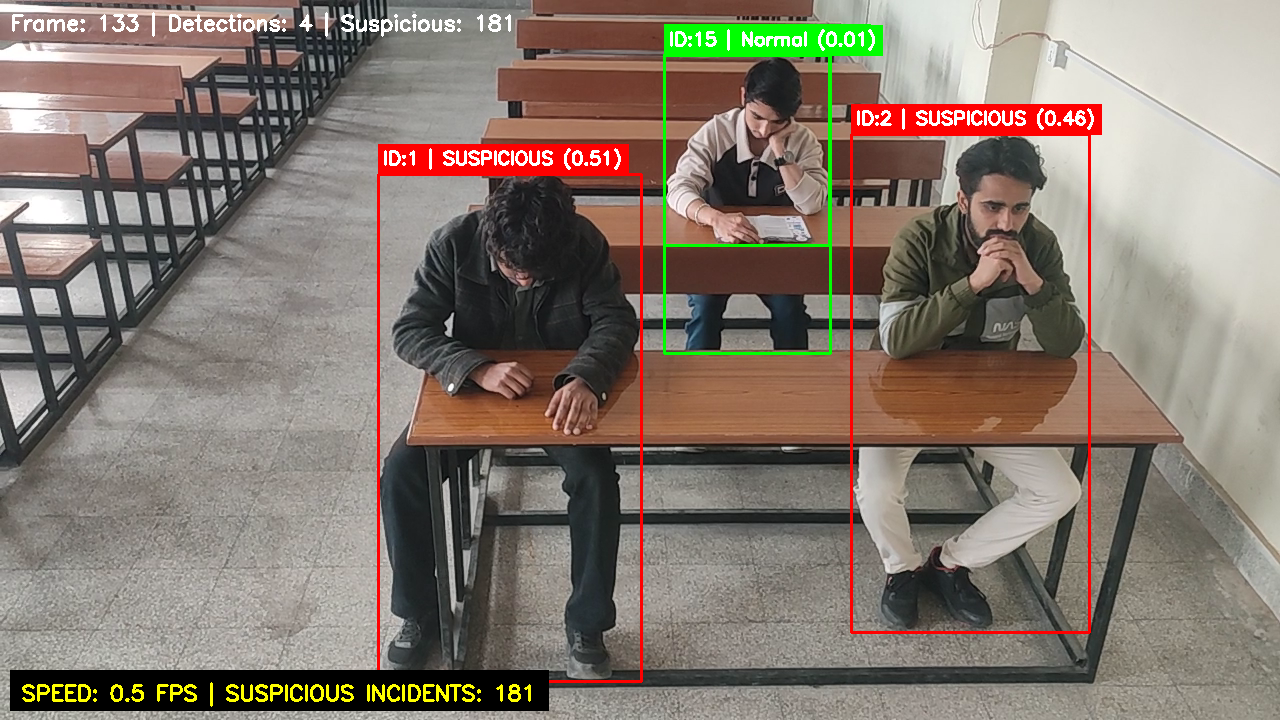


✅ COMPLETE | Avg Speed: 0.45 FPS | Total Suspicious: 181


In [ ]:
# Process at 2 FPS (from 30 FPS video)
process_video_realtime(
    video_path=video_path,
    output_fps=2,          # Process 2 frames per second
    display_every=1,       # Show every processed frame
    max_frames=None        # Process entire video
)

## 💾 9. Optional: Save Processed Video

If you want to save the output (although this defeats the real-time purpose):

# 30 FPS Processed Video Code

In [ ]:
import time
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from google.colab import files

def process_and_save_video(video_path, output_path='output_proctoring.mp4', display_every=15):
    # --- ERROR CHECK 1: Check if file exists ---
    if not os.path.exists(video_path):
        print(f"❌ Error: The file '{video_path}' does not exist in the Colab folder!")
        print("Check the 'Files' tab on the left to confirm the filename.")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: OpenCV could not open '{video_path}'. It might be a corrupted file.")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"🚀 Found Video: {width}x{height} at {fps} FPS")
    print(f"📹 Processing {total_frames} frames... Please wait.")

    frame_count = 0
    start_time = time.time()

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # AI Processing
            processed_frame, detections = pipeline.process_frame(frame)

            # Save to file
            out.write(processed_frame)
            frame_count += 1

            # Display Progress every N frames
            if frame_count % display_every == 0:
                elapsed = time.time() - start_time
                current_fps = frame_count / elapsed if elapsed > 0 else 0
                progress = (frame_count / total_frames) * 100

                # Show a preview
                display_frame = cv2.resize(processed_frame, (854, 480))
                clear_output(wait=True)
                print(f"Progress: {progress:.1f}% | Total Suspicious: {pipeline.suspicious_count}")
                cv2_imshow(display_frame)

    except Exception as e:
        print(f"❌ An error occurred during processing: {e}")

    finally:
        cap.release()
        out.release()

        if frame_count > 0:
            print(f"\n✅ Processing Finished! {frame_count} frames saved.")
            print(f"⬇️ Starting automatic download of {output_path}...")
            time.sleep(1) # Wait for file to close properly
            files.download(output_path)
        else:
            print("❌ No frames were processed. The loop never started.")

# --- RUN THE CODE HERE ---
# Make sure 'video_filename' matches the name of the file you uploaded!
process_and_save_video(video_path, display_every=15)

Progress: 5.9% | Total Suspicious: 196


# 2 FPS Processed Video Output

Progress: 96.2% | Processed: 115 frames | Suspicious: 174


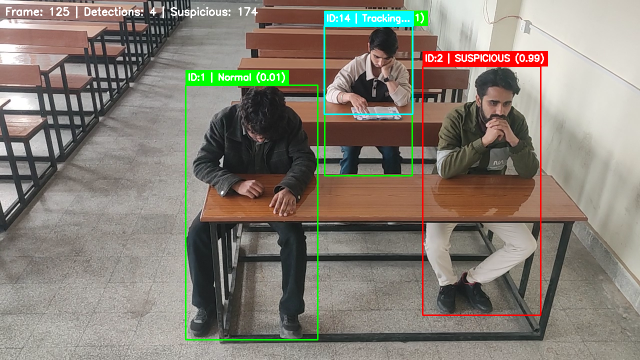

In [ ]:
import time
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow  # Fixes 'cv2_imshow' NameError
from IPython.display import clear_output
from google.colab import files              # Fixes 'files' NameError

def process_and_save_video_optimized(video_path, output_path='output_proctoring.mp4', output_fps=2):
    # Check if file exists
    if not os.path.exists(video_path):
        print(f"❌ Error: {video_path} not found.")
        return

    cap = cv2.VideoCapture(video_path)
    input_fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Frame skip logic: 30 / 2 = 15 (Process every 15th frame)
    frame_skip = max(1, int(input_fps / output_fps))

    # Setup video writer at 2 FPS
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, output_fps, (width, height))

    print(f"🚀 OPTIMIZED: Processing 1 frame every {frame_skip} frames.")
    print(f"📹 Saving at {output_fps} FPS. Total input frames: {total_frames}")

    frame_count = 0
    processed_count = 0
    start_time = time.time()

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # THE INDICATOR: This skips the heavy AI for 14 out of 15 frames
            if frame_count % frame_skip != 0:
                continue

            # AI Inference Stage
            processed_frame, detections = pipeline.process_frame(frame)

            # Save the processed frame
            out.write(processed_frame)
            processed_count += 1

            # Display update every 5 AI frames
            if processed_count % 5 == 0:
                clear_output(wait=True)
                progress = (frame_count / total_frames) * 100
                print(f"Progress: {progress:.1f}% | Processed: {processed_count} frames | Suspicious: {pipeline.suspicious_count}")

                # Show small preview to keep browser fast
                display_preview = cv2.resize(processed_frame, (640, 360))
                cv2_imshow(display_preview)

    except Exception as e:
        print(f"❌ Error: {e}")
    finally:
        cap.release()
        out.release()

        if processed_count > 0:
            print(f"✅ Finished! Saved {processed_count} frames to {output_path}.")
            print("⬇️ Download starting...")
            files.download(output_path)
        else:
            print("❌ No frames were saved. Check if video_path is correct.")

# Run the fixed code
process_and_save_video_optimized(video_path, output_fps=2)

## 📝 Notes and Tips

### Performance Optimization:
1. **Adjust `display_every`**: Higher values = faster processing
   - `display_every=1`: Show every frame (slowest, most detail)
   - `display_every=10`: Good balance
   - `display_every=30`: Faster processing

2. **Limit frames with `max_frames`**: Test on first N frames
   - `max_frames=100`: Process first 100 frames only
   - `max_frames=None`: Process entire video

3. **Pipeline is real-time**: Each frame goes through:
   ```
   Read Frame → YOLO Detect → DeepSORT Track →
   Generate Skeleton → ResNet Features → LSTM Classify → Display
   ```

### Key Differences from Original:
- ✅ **No batch processing**: Each frame processed immediately
- ✅ **No upload/download wait**: Results shown in real-time
- ✅ **Memory efficient**: No need to store all frames
- ✅ **Faster feedback**: See results as they happen

### Troubleshooting:
- If processing is slow, increase `display_every`
- If GPU memory issues, reduce video resolution
- For webcam: Browser permissions may cause delays